# Model Evaluation and Hyperparameter Tuning

1. Setup and Data Preparation

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Import multiple classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Load dataset (using wine dataset as example)
wine = datasets.load_wine()
X = wine.data
y = wine.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

2. Baseline Model Evaluation

In [2]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluate a model and return performance metrics
    """
    # Train model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    return {
        'model': str(model),
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'cv_mean': np.mean(cv_scores),
        'cv_std': np.std(cv_scores)
    }

# Initialize models
models = [
    LogisticRegression(max_iter=10000, random_state=42),
    SVC(random_state=42),
    RandomForestClassifier(random_state=42),
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

# Evaluate all models
results = []
for model in models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test)
    results.append(result)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df.sort_values(by='f1_score', ascending=False))

                                               model  accuracy  precision  \
0  LogisticRegression(max_iter=10000, random_stat...  1.000000   1.000000   
1                               SVC(random_state=42)  1.000000   1.000000   
2            RandomForestClassifier(random_state=42)  1.000000   1.000000   
5  XGBClassifier(base_score=None, booster=None, c...  0.944444   0.951389   
4            DecisionTreeClassifier(random_state=42)  0.944444   0.946296   
3                             KNeighborsClassifier()  0.944444   0.949383   

     recall  f1_score   cv_mean    cv_std  
0  1.000000  1.000000  0.979064  0.017100  
1  1.000000  1.000000  0.971921  0.014050  
2  1.000000  1.000000  0.978571  0.028571  
5  0.944444  0.944856  0.943350  0.028341  
4  0.944444  0.943997  0.915271  0.018323  
3  0.944444  0.943604  0.950985  0.035372  


3. Hyperparameter Tuning with GridSearchCV

In [3]:
# Example for SVM
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

svm_grid = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=svm_param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train)

# Get best model and parameters
best_svm = svm_grid.best_estimator_
best_svm_params = svm_grid.best_params_

# Evaluate best model
svm_result = evaluate_model(best_svm, X_train, y_train, X_test, y_test)
print("Best SVM Performance:")
print(svm_result)
print("Best Parameters:")
print(best_svm_params)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best SVM Performance:
{'model': "SVC(C=0.1, kernel='linear', random_state=42)", 'accuracy': 0.9722222222222222, 'precision': 0.9753086419753088, 'recall': 0.9722222222222222, 'f1_score': 0.9725248123940935, 'cv_mean': np.float64(0.97192118226601), 'cv_std': np.float64(0.014050207583203595)}
Best Parameters:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


4. Hyperparameter Tuning with RandomizedSearchCV

In [4]:
from scipy.stats import uniform, randint

# Example for Random Forest
rf_param_dist = {
    'n_estimators': randint(50, 500),
    'max_depth': [None, 5, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', None]
}

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=50,  # Number of parameter settings to sample
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_random.fit(X_train, y_train)

# Get best model and parameters
best_rf = rf_random.best_estimator_
best_rf_params = rf_random.best_params_

# Evaluate best model
rf_result = evaluate_model(best_rf, X_train, y_train, X_test, y_test)
print("Best Random Forest Performance:")
print(rf_result)
print("Best Parameters:")
print(best_rf_params)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Performance:
{'model': 'RandomForestClassifier(min_samples_leaf=3, min_samples_split=3,\n                       n_estimators=102, random_state=42)', 'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'cv_mean': np.float64(0.9785714285714286), 'cv_std': np.float64(0.028571428571428557)}
Best Parameters:
{'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 102}


5. Comparing All Tuned Models

                                               model  accuracy  precision  \
1  RandomForestClassifier(min_samples_leaf=3, min...  1.000000   1.000000   
0       SVC(C=0.1, kernel='linear', random_state=42)  0.972222   0.975309   

     recall  f1_score   cv_mean    cv_std  
1  1.000000  1.000000  0.978571  0.028571  
0  0.972222  0.972525  0.971921  0.014050  


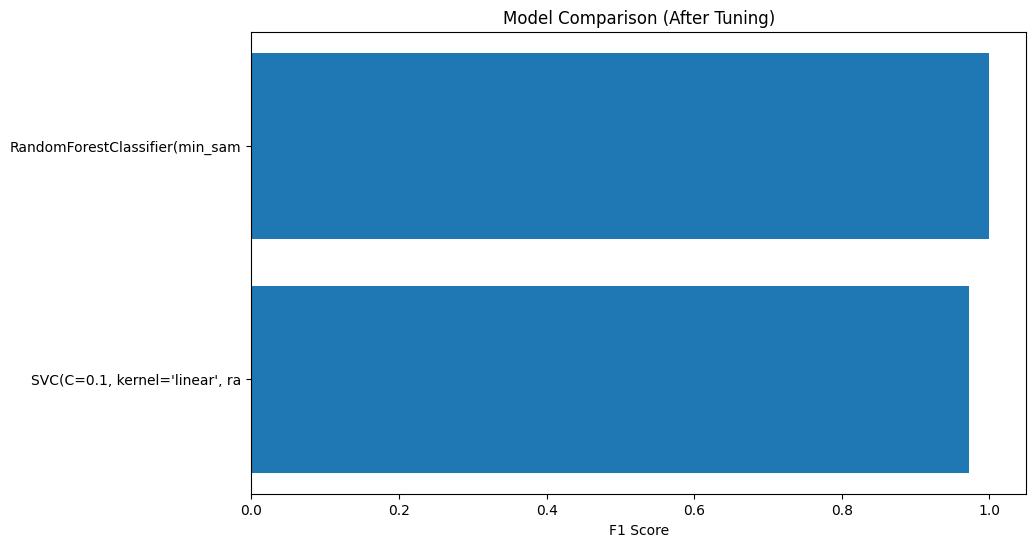

In [5]:
# Create list of tuned models
tuned_models = [
    best_svm,
    best_rf,
    # Add other tuned models here
]

# Evaluate all tuned models
tuned_results = []
for model in tuned_models:
    result = evaluate_model(model, X_train, y_train, X_test, y_test)
    tuned_results.append(result)

# Convert results to DataFrame
tuned_results_df = pd.DataFrame(tuned_results)
print(tuned_results_df.sort_values(by='f1_score', ascending=False))

# Visual comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(tuned_results_df['model'].str[:30], tuned_results_df['f1_score'])
plt.xlabel('F1 Score')
plt.title('Model Comparison (After Tuning)')
plt.show()